# Lab #1: Solutions
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as sp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise: Simulation of Statistical Models

## Model of USPS Package Processing Time

In this problem we want to model how much time it takes an USPS package processing system to process packages that arrive in a day. 

**Assumptions:**
1. packages arrive randomly in any given hour according to a Poisson distribution. That is, the number of packages $N$ is distributed as $Poi(\lambda)$, with $\lambda = 3$.
2. each package has a randomn size $S$ (measured in $in^3$) and weight $W$ (measured in pounds) jointly distributed as $\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 1.5& 1\\ 1 & 1.5 \end{array} \right] \right)$.
3. processing time $T$ (in seconds) for each package is given by $T = 60 + 0.6 W + 0.2 S + \epsilon$, $\epsilon \sim \mathcal{N}(0, 5)$.

**Tasks:**
1. Compute the expected total weight and size of packages that arrive over a single day. Compute the expected average weight and size of packages that arrive over a single day.
2. Compute the expected number of packages that arrives in a single day.
3. Compute the expected processing time of a single package.
4. Compute the expected processing time of all packages over a single day.

**Solutions:**
Before tackling the various computations, let's get an intuitive understanding of the various distributions for number of packages, package weight and size etc. To do this, we visualize the distributions and ask ourselves if they realistically model the real-life quantities in which we are interested.

**Number of Packages as a Random Variable**

We first visualize the Poisson distribution that describes the number of packages that arrives in one hour. You can either plot the pmf of the Poisson distribution (available through `scipy.stats.poisson` ) as a function using `.plot()` or you can sample from the distribution using `numpy.random.poisson` then histogram the samples using `.hist()` to empirically approximate the pmf.

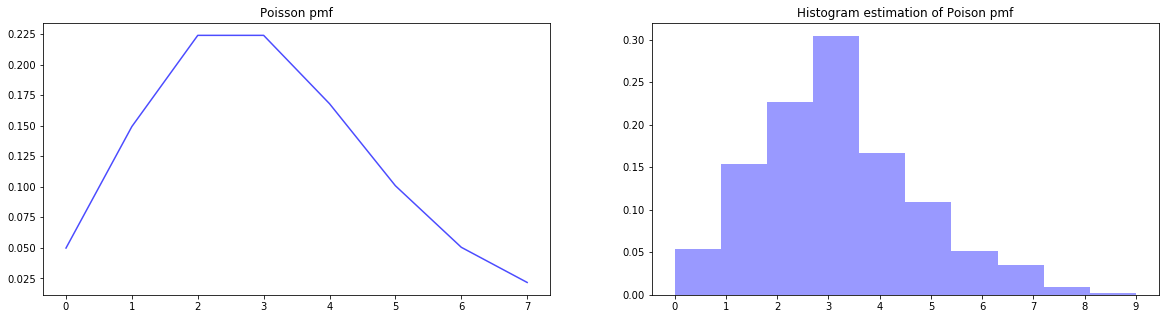

In [55]:
#parmater for the poisson distribution
mu = 3
#define x values that include most of the probability mass of the pmf
x = np.arange(sp.stats.poisson.ppf(0.01, mu), sp.stats.poisson.ppf(0.99, mu))
#get the poisson pmf function from scipy.stats
poisson_pmf = sp.stats.poisson(mu).pmf

#sample 500 values from numpy's poisson distribution
samples = np.random.poisson(mu, size=500)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#plot the poisson pmf as a function
ax[0].plot(x, poisson_pmf(x), color='blue', alpha=0.7)
ax[0].set_title('Poisson pmf')
#approximate the poisson pmf by histogramming the samples
ax[1].hist(samples, bins=10, density=True, color='blue', alpha=0.4)
ax[1].set_xticks(range(samples.max() + 1))
ax[1].set_title('Histogram estimation of Poison pmf')
plt.show()

From the pmf, we can see that it's more likely that 1-4 packages arrive in an hour and it's much less likely that more than 5 packages arrive in an hour.

---

**Size and Weight of the Packages as Random Variables**

Again, to visualize the bivariate Guassian distribution for the size and weight, we can visualize the pdf as a bivariate function (using heatmaps and contour maps) or we can sample from the distribution and visualize a scatter plot (the scatter plot is an approximation of the pdf).

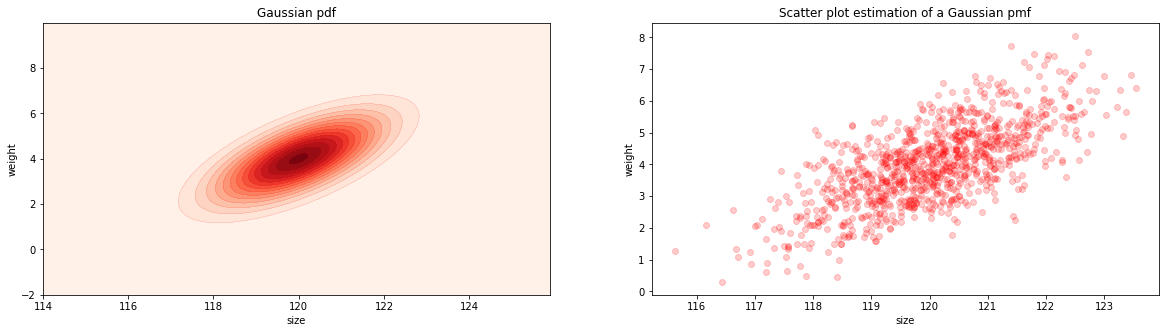

In [68]:
#mean of the multivariate Gaussian
mu = [120, 4]
#covariance matrix of the multivariate Gaussian
Sigma = np.ones((2, 2)) + 0.5 * np.eye(2)

#define points that include most of the probability mass of the pdf
x, y = np.mgrid[114:126:.1, -2:10:.01]
pos = np.dstack((x, y))
#get the value of the pdf at those points
z = sp.stats.multivariate_normal(mu, Sigma).pdf(pos)

#sample 1000 points from numpy's multivariate normal distribution
samples = np.random.multivariate_normal(mu, Sigma, size=1000)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#plot the gaussian pdf as a heat-map
ax[0].contourf(x, y, z, levels=14, cmap='Reds')
#plot the gaussian pdf as a countour map
ax[0].contour(x, y, z, levels=14, linewidths=0.1, colors='red')
ax[0].set_title('Gaussian pdf')
ax[0].set_xlabel('size')
ax[0].set_ylabel('weight')
#approximate the gaussian pdf by scatter plotting the samples
ax[1].scatter(samples[:, 0], samples[:, 1], color='red', alpha=0.2)
ax[1].set_title('Scatter plot estimation of a Gaussian pmf')
ax[1].set_xlabel('size')
ax[1].set_ylabel('weight')
plt.show()

We see that the most likely values under this Gaussian distribution are around 120 $cm^3$ and 4 lbs. This Gaussian distribution is skewed diagonally towards the right. What does this mean about the relationship between the two random variables: size and weight?

***Important Exploration for Intuition:***
Can you see which components of the covariance matrix contorl which aspect of the shape of the Gaussian pdf? Specifically, which aspect of the shape do the diagonal entries control? Which aspect of the shape do the off diagonal entries control? Change some of the values in $\left[\begin{array}{cc} 1.5& 1\\ 1 & 1.5 \end{array} \right]$ and see how the shape of the pdf is effected. 

---

**Processing Time as a Random Variable**

What about the distribution of the processing time as a random variable? This is more complex since total processing time over a day, $T_{\text{total}}$, is a function of other random variables,
\begin{aligned}
T_{\text{total}} &= \sum_{m=1}^{24}\sum_{n=1}^{N_m} 60 + 0.6 W_n + 0.2 S_n + \epsilon_n \\
\epsilon_n &\sim \mathcal{N}(0, 5)\\
[S_n, W_n] &\sim \mathcal{N}\left([120, 4], \left[\begin{array}{cc} 1.5& 1\\ 1 & 1.5 \end{array} \right] \right)\\
N_m &\sim Poi(3)
\end{aligned}

As such, we don't know what exactly is the distribution of $T_{\text{total}}$ (i.e. it's not a normal distribution, it's not Poisson etc). In this case, we can't easily plot the pdf of $T_{\text{total}}$ as we did for the other random variables. We can, however, still approximate the pdf by sampling from the distribution of $T_{\text{total}}$. Rather than sampling from a specific pdf (in this case we don't know what it is), we can "build" samples of $T_{\text{total}}$, by sampling all relevant random variables on which $T_{\text{total}}$ depends and then summing them appropriately to obtain samples of $T_{\text{total}}$.

In [58]:
def sample_total_time():
    '''
    function to simulate one sample of total processing time T_total
    '''
    #sample packages per hour for 24 hours
    mu = 3
    samples = np.random.poisson(mu, size=24)
    #sum hourly number of packages to get total number over 24 hours
    total_packages = samples.sum()
    #for each package sample a size and weight
    mu = [120, 4]
    Sigma = np.ones((2, 2)) + 1.5 * np.eye(2)
    size_weight_samples = np.random.multivariate_normal(mu, Sigma, size=total_packages)
    #sample epsilons
    epsilons = np.random.normal(0, 5, size=total_packages)
    
    #compute total processing time for all packages
    T_total = (60 + 0.6 * size_weight_samples[:, 1] + 0.2 * size_weight_samples[:, 0] + epsilons).sum()
    
    return T_total

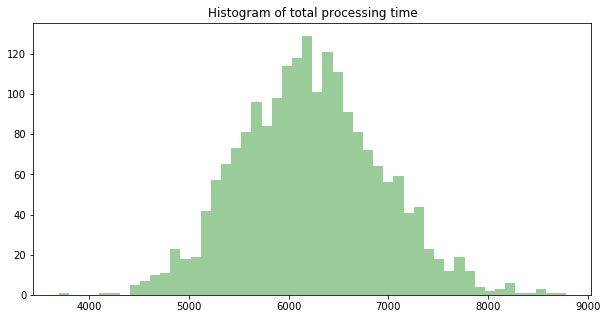

In [67]:
#simulate 2000 samples of total processing time
number_of_samples = 2000
total_times = []
for n in range(number_of_samples):
    total_times.append(sample_total_time())

#visualize the total processing time samples
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(total_times, bins=50, color='green', alpha=0.4)
ax.set_title('Histogram of total processing time')
plt.show()

it looks like that the most likely total processing time over a day is just above 6000 seconds, or 1.67 hours.

---

**Computing the Various Expectations**

1. Compute the expected total weight and size of packages that arrive over a single day. Compute the expected average weight and size of packages that arrive over a single day.

The expression for the total weight and size of packages is:
\begin{aligned}
W_{\text{total}} &= \sum_{m=1}^{24}\sum_{n=1}^{N_m} W_{n}\\
S_{\text{total}} &= \sum_{m=1}^{24}\sum_{n=1}^{N_m} S_{n}
\end{aligned}

***Analytic Solution***
Note that the total weight $W_{\text{total}}$ (and respectively, size) depends on both the random variables $W_{n}$ and the random variables $N_{m}$. Thus, when we take the expected (or "average") value of $W_{\text{total}}$ (and respectively, size), we must take the expectation with repect to both $W_{n}$'s and $N_{m}$'s:
$$
\mathbb{E}_{\{W_n\}, \{N_m\}}W_{\text{total}} = \mathbb{E}_{\{W_n\}, \{N_m\}} \sum_{m=1}^{24}\sum_{n=1}^{N_m} W_{n}.
$$

Recall the definition of the expected value of a function of a random variable, $x$
$$
\mathbb{E}_{x}[f(x)] = \int f(x) p(x) dx,
$$
where $p(x)$ is the pdf of the random variable $x$.

So, we can write (with slight abuses of notation for simplicity):
\begin{aligned}
\mathbb{E}_{\{W_n\}, \{N_m\}}W_{\text{total}} &= \int_{\{W_n\}, \{N_m\}}W_{\text{total}} p\left(\{W_n\}, \{N_m\}\right) d\{W_n\}d\{N_m\}\\
&= \int_{\{W_n\}, \{N_m\}} \sum_{m=1}^{24}\sum_{n=1}^{N_m} W_{n} p\left(\{W_n\}, \{N_m\}\right)d\{W_n\}d\{N_m\}
\end{aligned}
where $p\left(\{W_n\}, \{N_m\}\right)$ is the joint distribution of the $W_{n}$'s and the $N_{m}$'s. As you'll see, we don't need to know anything about the distribution $p\left(\{W_n\}, \{N_m\}\right)$, or compute any of these integrals. The only fact of integration we need to recall is that ***the integral is a linear operator***, that is, integration is interchangeable with finite sums. I.e. we can interchange the order of the integral and the first summand:
\begin{aligned}
\int_{\{W_n\}, \{N_m\}} \sum_{m=1}^{24}\sum_{n=1}^{N_m} W_{n} p\left(\{W_n\}, \{N_m\}\right)d\{W_n\}d\{N_m\} &=
\sum_{m=1}^{24}\int_{\{W_n\}, \{N_m\}} \sum_{n=1}^{N_m} W_{n} p\left(\{W_n\}, \{N_m\}\right)d\{W_n\}d\{N_m\}\\
&= \sum_{m=1}^{24} \mathbb{E}_{\{W_n\}, \{N_m\}} \sum_{n=1}^{N_m} W_{n}
\end{aligned}
Now, since the second summand $\sum_{n=1}^{N_m}$ involves the random variable $N_m$ over which we are integrating, we cannot push the integral past this summand. Fortunately, it is a property of expectations that ***the expected value of a random sum of random variables (with the identical means) is the producted of the expected length of the sum and the expected value of one of the random variables***. That is,
\begin{aligned}
\sum_{m=1}^{24} \mathbb{E}_{\{W_n\}, \{N_m\}} \sum_{n=1}^{N_m} W_{n} = \sum_{m=1}^{24}\mathbb{E}_{\{W_n\}, \{N_m\}}[N_m ] \mathbb{E}_{\{W_n\}, \{N_m\}}[W_1]
\end{aligned}
But we modeled $N_m$ as a Poisson variable and so it's mean is $\lambda=3$; and we modeled $W_1$ as a normal variable with mean 4. Thus, we have that
$$
\mathbb{E}_{\{W_n\}, \{N_m\}}W_{\text{total}} = \sum_{m=1}^{24}\mathbb{E}_{\{W_n\}, \{N_m\}}[N_m ] \mathbb{E}_{\{W_n\}, \{N_m\}}[W_1] = 24 * 3 * 4 = 288.
$$
That is, the expected (or average) total weight processed by this USPS facility is 288 lbs.

***Solution via Simulation***
If we were unable (or unwilling) to compute these expectations analytically, we could have estimated $\mathbb{E}_{\{W_n\}, \{N_m\}}W_{\text{total}}$ through simulation. That is, we
1. simulate (sample) the number of packages that would arrive in a hour, and then repeat this 24 times
2. for each package in the 24 hours, we simulate (sample) a size and a weight
3. we sum up the size and the weight for the total over 24 hours
4. repeat this entire process a large number of times and compute the averaged total weight over the repetitions

In [77]:
#repeat a 24 hr simulation for 100 times
total_size_weight = []
for n in range(100):
    #simulate number of packages in 24 hours
    samples = np.random.poisson(3, size=24)
    total_packages = samples.sum()
    #for each package sample a size and weight
    mu = [120, 4]
    Sigma = np.ones((2, 2)) + 1.5 * np.eye(2)
    size_weight_samples = np.random.multivariate_normal(mu, Sigma, size=total_packages)
    #sum up the weights and sizes separately and add this total to our list of totals
    total_size_weight.append(size_weight_samples.sum(axis=0))

#average the total size and weight over 100 simulations
total_size_weight = np.array(total_size_weight).mean(axis=0)

#store both averages in a pandas dataframe (for pretty output)
total_df = pd.DataFrame(data=total_size_weight.reshape((1, -1)), columns=['total size', 'total weight'])
total_df

,total size,total weight
0,8553.200149,283.405526


This is pretty close to what we predicted analytically for the total weight!

2. Compute the expected number of packages that arrives in a single day.


***Analytic Solution***
The expression for the total number of packages that arrives in a single day is:
$$
N_{\text{total}} = \sum_{m=1}^{24} N_m
$$
where $N_m$ is the number of packages that arrives in a single hour. Note that $N_m \sim Poi(3)$.

  Thus,
\begin{aligned}
\mathbb{E}_{\{N_m\}} N_{\text{total}} = \mathbb{E}_{\{N_m\}}\sum_{m=1}^{24} N_m = \sum_{m=1}^{24}\mathbb{E}_{\{N_m\}}N_m = \sum_{m=1}^{24} 3 = 24 * 3 = 72
\end{aligned}

  Again, we can approximate $\mathbb{E}_{\{N_m\}} N_{\text{total}}$ through simulation.


3. Compute the expected processing time of a single package.

***Analytic Solution***

  The expression for a single package is
$$
T = 60 + 0.6 W + 0.2 S + \epsilon.
$$
  Thus, $T$ is a random variable that depends on $W$, $S$ and $\epsilon$. So when we compute the expected value of $T$, we need to take the expectation with respect to $W$, $S$ and $\epsilon$:
\begin{aligned}
\mathbb{E}_{W, S, \epsilon}[T] &= \mathbb{E}_{W, S, \epsilon}[60 + 0.6 W + 0.2 S + \epsilon]\\
&= \mathbb{E}_{W, S, \epsilon}[60] + 0.6\mathbb{E}_{W, S, \epsilon}[W] + 0.2\mathbb{E}_{W, S, \epsilon}[S] + \mathbb{E}_{W, S, \epsilon}[\epsilon]\\
&= 60 + 0.6 * 4 + 0.2 * 120 + 0\\
&= 86.4
\end{aligned}

  We've already written a simulation for $T$ as part of the function `sample_total_time()`, we could have estimated $\mathbb{E}_{W, S, \epsilon}[T]$ using simulations.
  
4. Compute the expected processing time of all packages over a single day.

***Analytic Solution***

  The expression for a single package is
  $$
  T_{\text{total}} = \sum_{m=1}^{24}\sum_{n=1}^{N_m} 60 + 0.6 W_n + 0.2 S_n + \epsilon_n 
  $$
  Thus, $T_{\text{total}}$ is a random variable that depends on the variables $\{N_m\}$, $\{W_n\}$, $\{S_n\}$ and $\{\epsilon_n\}$. So when we compute the expected value of $T$, we need to take the expectation with respect to all the variables on which $T_{\text{total}}$ depends:
    \begin{aligned}
    \mathbb{E}_{\text{all vars}}[T_{\text{total}}] &= \mathbb{E}_{\text{all vars}}\sum_{m=1}^{24}\sum_{n=1}^{N_m} 60 + 0.6 W_n + 0.2 S_n + \epsilon_n \\
    &= \sum_{m=1}^{24}\mathbb{E}_{\text{all vars}}\sum_{n=1}^{N_m} 60 + 0.6 W_n + 0.2 S_n + \epsilon_n\\
    &= \sum_{m=1}^{24} \mathbb{E}_{\text{all vars}}[N_m] (\mathbb{E}_{\text{all vars}}[60 + 0.6 W_n + 0.2 S_n + \epsilon_n])  \\
    &= \sum_{m=1}^{24} 3 * 86.4\\
    &= 24 * 3 * 86.4\\
    &= 6220.8
    \end{aligned}
    where we used the fact that $\mathbb{E}_{\text{all vars}}[60 + 0.6 W_n + 0.2 S_n + \epsilon_n] = 86.4$ from Question 3.
    
    ***Solution via Simulation***
    
    At the beginning of this notebook, we'd simulated samples from the distribution of $T_{\text{total}}$. So we can use the empirical mean of the samples in order to estimate the $\mathbb{E}_{\text{all vars}}[T_{\text{total}}]$.

In [79]:
#estimate the empirical mean of the total processing time
np.mean(total_times)

6216.313718424067

This look close to our analytically computed expected value!

---

### The Main Take-away:

It is often the case that we are interested in computing some statistics (like the average) of a quantity that is a function of random variables (like total processing time, which is a function of weight, size etc). If we know the analytical form (the formula for the pdf or pmf) of the random involved and if the function is relatively simple, we can often compute these statistics analytically (by computint the various integrals exactly). 

When analytical computation is intractable, we want to simulate samples from the quantity of interest (e.g. simulate samples from total process time) and then estimate the statistic empirically using samples.